In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

PATH_TO_DATA = '../data/'
PATH_TO_OUTPUT_DATA = '../output-data/'
PATH_TO_MODEL_DATA = '../model-data/'

In [2]:
from sklearn.model_selection import train_test_split

In [4]:
MLB_DF = pd.read_csv(PATH_TO_OUTPUT_DATA + 'MLB_INPUT.csv')

In [7]:
MLB_DF['home_ISO'] = MLB_DF['home_SLG'] - MLB_DF['home_AVG']
MLB_DF['away_ISO'] = MLB_DF['away_SLG'] - MLB_DF['away_AVG']
MLB_DF['ISO_difference'] = MLB_DF['home_ISO'] - MLB_DF['away_ISO']
MLB_DF['ISO_difference_PCT'] = (MLB_DF['home_ISO'] - MLB_DF['away_ISO'])/ MLB_DF['home_ISO']*100

In [8]:
MLB_DF.head()

,dt,Y,M,D,away_team,home_team,away_pitcher_id,home_pitcher_id,outcome,home_AVG,...,home_ELO,away_ELO,ELO_difference,E[ELO],home_rest,away_rest,home_ISO,away_ISO,ISO_difference,ISO_difference_PCT
0,2001-04-01,2001,4,1,TEX,TOR,hellr001,loaie001,1,0.273459,...,1496.828252,1462.450742,34.377511,0.597675,5,5,0.192927,0.161597,0.031331,16.239572
1,2001-04-02,2001,4,2,SLN,COL,kiled001,hampm001,1,0.290176,...,1487.470945,1529.964302,-42.493357,0.380077,5,5,0.158088,0.182953,-0.024866,-15.729076
2,2001-04-02,2001,4,2,SDN,SFN,willw001,hernl003,1,0.276079,...,1544.173611,1478.296302,65.877309,0.681015,5,5,0.192446,0.146424,0.046022,23.914199
3,2001-04-02,2001,4,2,MIL,LAN,wrigj001,parkc002,1,0.254198,...,1527.653270,1509.946671,17.706599,0.550788,5,5,0.172233,0.156534,0.015699,9.115030
4,2001-04-02,2001,4,2,ATL,CIN,burkj001,harnp001,0,0.272199,...,1544.192550,1512.406489,31.786061,0.590480,5,5,0.171600,0.155356,0.016244,9.466322


### 1. Group into years 

In [231]:
def create_features(data, pct = True):
    features = data.drop(labels = 
                       ['dt', 'Y', 'M', 'D', 'away_team', 
                        'home_team', 'away_pitcher_id', 'home_pitcher_id',
                       'date'],
                      axis = 1)
    features['rest_difference'] = features['home_rest'] - features['away_rest']
    features['ELO_difference_PCT'] = features['ELO_difference']/features['home_ELO']*100
    if (pct == True):
        PCT_DIFF = features[[i for i in list(features) if 'PCT' in i] + ['rest_difference', 'outcome']]
        PCT_DIFF_features = [i for i in list(features) if 'PCT' in i] + ['rest_difference']
        return PCT_DIFF[PCT_DIFF_features], PCT_DIFF['outcome']
    else:
        DIFF = features[[i for i in list(features) if 
                         (('difference' in i) and ('PCT' not in i))] + ['outcome']]
        DIFF_features = [i for i in list(features) if 
                        (('difference' in i) and ('PCT' not in i))] + []
        return DIFF[DIFF_features], DIFF['outcome']


In [218]:
# splits season into 3/4 for train, 1/4 for test
def seasonal_train_test_split(X, Y):
    test_train_cutoff = int(len(X)*.75)
    x_train = X[0:test_train_cutoff]
    x_test = X[test_train_cutoff:]
    y_train = Y[0:test_train_cutoff]
    y_test = Y[test_train_cutoff:]
    
    return x_train, x_test, y_train, y_test

In [219]:
# Generate 
def create_yearly_samples(MLB_DF = MLB_DF):
    years = list(set(MLB_DF.Y))
    YEARLY_DATA = {}
    for i in years:
        YEARLY_MLB = create_features(MLB_DF[MLB_DF.Y == i])
        x_train, x_test, y_train, y_test = seasonal_train_test_split(YEARLY_MLB[0], YEARLY_MLB[1])
        YEARLY_DATA[i] = {
            'x_train': x_train,
            'x_test': x_test,
            'y_train': y_train,
            'y_test': y_test
        }
    return YEARLY_DATA

In [101]:
# Create our yearly df
MLB_FINAL_DATA = create_yearly_samples()

### 2. Create feature label

In [102]:
# # UNUSED
# PCT_DIFF = features[[i for i in list(features) if 'PCT' in i] + ['E[ELO]', 'rest_difference', 'outcome']]
# PCT_DIFF_features = [i for i in list(features) if 'PCT' in i] + ['E[ELO]', 'rest_difference']

# DIFF = features[[i for i in list(features) if (('difference' in i) & ('PCT' not in i))] + [
#     'E[ELO]', 'outcome']]
# DIFF_features = [i for i in list(features) if (('difference' in i) & ('PCT' not in i))] + [
#     'E[ELO]']

In [103]:
# standard features
features = create_features(MLB_DF)
X, Y = features[0], features[1]

### Brief EDA

In [104]:
import numpy as np
np.corrcoef([1 if x > .5 else 0 for x in MLB_DF['E[ELO]']], MLB_DF['outcome'])

array([[1.        , 0.08780784],
       [0.08780784, 1.        ]])

Thank you: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

In [1]:
# # correlation plots
plt.figure(figsize=(8,8))
cor = MLB_DF.corr()
cor = cor.apply(lambda x: round(100*x)/100)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()

NameError: name 'plt' is not defined

In [106]:
#Correlation with output variable
cor_target = abs(cor['ISO_difference'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target >= 0.2]
relevant_features

outcome               0.21
home_AVG              0.32
home_OBP              0.33
home_SLG              0.62
away_AVG              0.32
away_OBP              0.32
away_SLG              0.61
AVG_difference        0.46
OBP_difference        0.46
SLG_difference        0.90
AVG_difference_PCT    0.46
OBP_difference_PCT    0.46
SLG_difference_PCT    0.88
home_ELO              0.22
away_ELO              0.22
ELO_difference        0.31
E[ELO]                0.31
home_ISO              0.68
away_ISO              0.67
ISO_difference        1.00
ISO_difference_PCT    0.92
Name: ISO_difference, dtype: float64

### 3. Train-test split
Looking at PCT differences only

In [107]:
# PCT DIFF
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size = 0.2, random_state = 499
)

In [108]:
x_train.describe()

,AVG_difference_PCT,OBP_difference_PCT,SLG_difference_PCT,IP_Start_difference_PCT,ERA_difference_PCT,WHIP_difference_PCT,BAA_difference_PCT,K9_difference_PCT,HR9_difference_PCT,K/BB_difference_PCT,FIP_difference_PCT,ISO_difference_PCT,ELO_difference_PCT,rest_difference
count,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000
mean,-1.013753,-0.353648,-1.762579,-0.517322,-3.792635,-1.224264,-0.784944,-3.451836,-8.107719,-9.575041,-2.397757,-7.650092,-0.045809,0.005176
std,17.394966,14.730360,22.250893,10.964865,28.699998,14.908714,12.060618,28.450092,46.624491,54.147190,22.251927,46.460539,3.148565,2.497672
min,-109.282700,-83.205575,-157.825203,-163.040201,-314.942529,-129.224270,-88.622754,-235.397317,-663.771712,-1048.387097,-233.875299,-661.572052,-12.576655,-182.000000
25%,-11.173356,-9.246454,-14.403381,-5.459970,-16.425000,-9.031170,-7.064856,-16.717338,-23.691012,-26.882163,-12.449907,-28.386657,-2.133602,0.000000
50%,0.394479,0.643160,0.537893,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.023691,0.036315,0.000000
75%,10.908716,9.717416,13.513514,5.283041,13.973734,7.949139,6.535948,14.623184,19.249742,22.500019,10.944823,23.186105,2.119065,0.000000
max,54.131151,45.784566,58.864957,67.401098,72.267537,54.189019,44.578313,73.482284,88.837353,90.411985,69.885542,86.970515,12.373090,189.000000


In [109]:
x_test.describe()

,AVG_difference_PCT,OBP_difference_PCT,SLG_difference_PCT,IP_Start_difference_PCT,ERA_difference_PCT,WHIP_difference_PCT,BAA_difference_PCT,K9_difference_PCT,HR9_difference_PCT,K/BB_difference_PCT,FIP_difference_PCT,ISO_difference_PCT,ELO_difference_PCT,rest_difference
count,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000
mean,-0.918526,-0.392223,-1.848003,-0.725574,-3.137996,-0.622726,-0.549185,-3.946884,-8.020901,-11.737532,-1.824391,-8.143427,-0.102615,-0.019185
std,17.488899,14.844921,22.720465,10.432756,28.532395,14.694322,12.098299,28.308409,46.881884,55.305329,21.896484,47.733615,3.153391,1.842221
min,-100.687467,-80.906050,-173.263305,-83.898305,-217.307692,-91.175359,-60.674157,-269.458128,-532.543444,-861.419753,-177.535056,-690.004131,-12.576655,-175.000000
25%,-10.729833,-9.278354,-14.664288,-5.885347,-15.823828,-8.085944,-6.660839,-17.377754,-23.454034,-30.284635,-11.811086,-29.501492,-2.226193,0.000000
50%,0.499993,0.621195,0.701127,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.761052,-0.049613,0.000000
75%,10.896330,9.752750,13.716618,4.999862,14.638685,8.432584,6.746032,13.860532,19.109688,20.349827,11.457180,23.403565,2.064447,0.000000
max,51.130637,45.409988,57.058195,59.870942,66.526611,49.378578,45.779221,71.481981,81.835443,85.627694,67.449498,81.968811,11.307956,4.000000


# Random selection models

### Logistic regression

```
>>> from sklearn.model_selection import cross_val_score
>>> clf = svm.SVC(kernel='linear', C=1)
>>> scores = cross_val_score(clf, X, y, cv=5)
```

In [110]:
# imports
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import math

In [111]:
X = features[0]
Y = features[1]

In [112]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = 0.75, random_state = 499)

In [113]:
# data: x1_train, x1_test, y1_train, y1_test
logit = LogisticRegression(
    penalty = 'l2', 
    fit_intercept = True,
    random_state = 499, 
)

In [114]:
logit.fit(x_train, y_train)
logit.score(x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.622152850040467

In [115]:
scores = cross_val_score(logit, x_train, y_train, cv=10)
print("Accuracy: %0.3f (+/- %0.3f)" % (
    scores.mean(), scores.std() * 2))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.622 (+/- 0.019)


In [116]:
sum(logit.predict(x_test) == y_test)/len(y_test)

0.6265175164758932

In [117]:
# compute logit outcomes
def compute_logit_probabilities(logit, x_test):
    logit_probs = [math.exp(x)/(1 + math.exp(x)) for x in list((logit.decision_function(x_test)))]
    return logit_probs

# check lift
def compute_lift_probabilities(x_test_probs, y_test, bin_width = 0.05):
    '''
    bin_width is probability increments
    '''
    
    y_pred = pd.DataFrame(dict(zip(logit_probs, y_test)), 
                 index = ['y']).T.reset_index().rename({'index': 'yhat'}, axis = 1)
    y_pred['buckets'] = y_pred['yhat'].apply(lambda x: round(x/bin_width)*bin_width)
    return y_pred

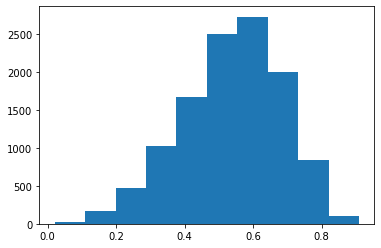

In [118]:
logit_probs = compute_logit_probabilities(logit, x_test)
plt.hist(logit_probs)
plt.show()

### Logit modeling based on time of season

In [119]:
x_train, x_test, y_train, y_test = seasonal_train_test_split(X, Y)

In [120]:
logit.fit(x_train, y_train)
logit.score(x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6230200023124061

In [121]:
scores = cross_val_score(logit, x_train, y_train, cv=5)
print("Accuracy: %0.3f (+/- %0.3f)" % (
    scores.mean(), scores.std() * 2))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-

Accuracy: 0.623 (+/- 0.015)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:937: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [122]:
logit_probs = [math.exp(x)/(1 + math.exp(x)) for x in list((logit.decision_function(x_test)))]
y_pred = compute_lift_probabilities(logit_probs, y_test, bin_width = 0.03)
y_pred.groupby('buckets')['y'].count()

buckets
0.03      7
0.06      9
0.09     27
0.12     45
0.15     63
0.18     94
0.21    118
0.24    191
0.27    227
0.30    296
0.33    327
0.36    418
0.39    476
0.42    532
0.45    630
0.48    713
0.51    777
0.54    845
0.57    865
0.60    866
0.63    826
0.66    769
0.69    661
0.72    596
0.75    486
0.78    332
0.81    210
0.84     85
0.87     27
0.90      3
0.93      1
Name: y, dtype: int64

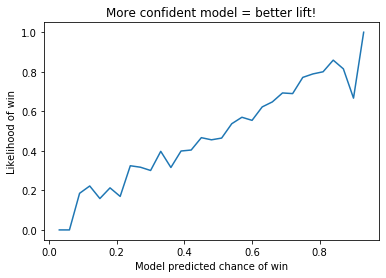

In [123]:
plt.plot(y_pred.groupby('buckets')['y'].mean())
plt.xlabel('Model predicted chance of win')
plt.ylabel('Likelihood of win')
plt.title('More confident model = better lift!')
plt.show()

### More regularized Logit

In [837]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import brier_score_loss, confusion_matrix, \
    roc_auc_score, roc_curve, auc, average_precision_score, precision_score

In [838]:
X, Y = create_features(MLB_DF, False)
x_train, x_test, y_train, y_test = seasonal_train_test_split(X, Y) # why standrardscale when you couldn't?


# x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = 0.75, random_state = 499)
logitCV = LogisticRegressionCV(cv = 5, random_state = 499)

In [839]:
logitCV.fit(x_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=499, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [840]:
logitCV.score(x_test, y_test)

0.6271245230662504

In [841]:
logit_probs = [math.exp(x)/(1 + math.exp(x)) for x in list((logitCV.decision_function(x_test)))]
brier_score_loss(y_test, logit_probs)

0.2266955677761798

In [129]:
confusion_matrix(y_test, logitCV.predict(x_test))

array([[2601, 2685],
       [1628, 4618]])

In [130]:
roc_auc_score(y_test, logitCV.predict(x_test))

0.6157038347902476

In [131]:
fpr, tpr, thresholds = roc_curve(y_test, logit_probs)

0.6706539328567938


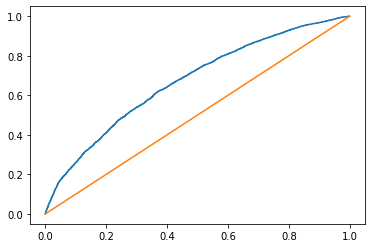

In [132]:
print(auc(fpr, tpr))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])

In [133]:
# average prediction
average_precision_score(y_test, logit_probs)

0.6959398003202922

In [134]:
precision_score(y_test, logitCV.predict(x_test))

0.6323428727920033

### Decision tree

In [135]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [136]:
clf = DecisionTreeClassifier(max_depth = 5, max_features = 1)

In [137]:
clf.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

[Text(177.8625, 199.32, 'X[6] <= -2.003\ngini = 0.497\nsamples = 34596\nvalue = [15993, 18603]'),
 Text(95.65714285714286, 163.07999999999998, 'X[1] <= 1.643\ngini = 0.489\nsamples = 13407\nvalue = [5726, 7681]'),
 Text(47.82857142857143, 126.83999999999999, 'X[12] <= -7.127\ngini = 0.498\nsamples = 6770\nvalue = [3591, 3179]'),
 Text(23.914285714285715, 90.6, 'X[10] <= 4.991\ngini = 0.46\nsamples = 123\nvalue = [79, 44]'),
 Text(11.957142857142857, 54.359999999999985, 'X[2] <= -4.184\ngini = 0.417\nsamples = 81\nvalue = [57, 24]'),
 Text(5.978571428571429, 18.119999999999976, 'gini = 0.399\nsamples = 69\nvalue = [50, 19]'),
 Text(17.935714285714287, 18.119999999999976, 'gini = 0.486\nsamples = 12\nvalue = [7, 5]'),
 Text(35.871428571428574, 54.359999999999985, 'X[0] <= -8.83\ngini = 0.499\nsamples = 42\nvalue = [22, 20]'),
 Text(29.892857142857142, 18.119999999999976, 'gini = 0.454\nsamples = 23\nvalue = [15, 8]'),
 Text(41.85, 18.119999999999976, 'gini = 0.465\nsamples = 19\nvalue = 

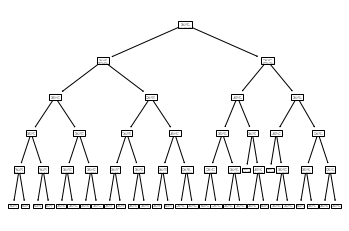

In [138]:
# Initial tree too much 
tree.plot_tree(clf.fit(x_train, y_train))

[Text(167.4, 199.32, 'X[11] <= 7.474\ngini = 0.497\nsamples = 34596\nvalue = [15993, 18603]'),
 Text(83.7, 163.07999999999998, 'X[2] <= -13.458\ngini = 0.498\nsamples = 19777\nvalue = [10578, 9199]'),
 Text(41.85, 126.83999999999999, 'X[0] <= -27.422\ngini = 0.467\nsamples = 8993\nvalue = [5649, 3344]'),
 Text(20.925, 90.6, 'X[1] <= -33.941\ngini = 0.413\nsamples = 2277\nvalue = [1613, 664]'),
 Text(10.4625, 54.359999999999985, 'X[9] <= 63.253\ngini = 0.324\nsamples = 601\nvalue = [479, 122]'),
 Text(5.23125, 18.119999999999976, 'gini = 0.316\nsamples = 594\nvalue = [477, 117]'),
 Text(15.693750000000001, 18.119999999999976, 'gini = 0.408\nsamples = 7\nvalue = [2, 5]'),
 Text(31.387500000000003, 54.359999999999985, 'X[9] <= 54.44\ngini = 0.438\nsamples = 1676\nvalue = [1134, 542]'),
 Text(26.15625, 18.119999999999976, 'gini = 0.432\nsamples = 1627\nvalue = [1113, 514]'),
 Text(36.61875, 18.119999999999976, 'gini = 0.49\nsamples = 49\nvalue = [21, 28]'),
 Text(62.775000000000006, 90.6, 

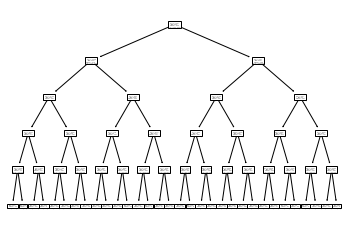

In [139]:
# TUNING
clf = DecisionTreeClassifier(max_depth = 5, max_features = 'log2', min_samples_split = 100, random_state = 499)
tree.plot_tree(clf.fit(x_train, y_train))

In [182]:
clf.fit(x_train, y_train)
pd.Series(clf.feature_importances_, index = x_train.columns).sort_values(ascending = False)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [142]:

# # correlation plots
# plt.figure(figsize=(8,8))
cor = x_train.corr()
cor = cor.apply(lambda x: round(100*x)/100)
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()
#Correlation with output variable
cor_target = abs(cor['ISO_difference_PCT'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target >= 0.2]
relevant_features

AVG_difference_PCT    0.43
OBP_difference_PCT    0.43
SLG_difference_PCT    0.86
ISO_difference_PCT    1.00
ELO_difference_PCT    0.28
Name: ISO_difference_PCT, dtype: float64

In [144]:
cor_target = abs(cor['FIP_difference_PCT'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target >= 0.2]
relevant_features

IP_Start_difference_PCT    0.42
ERA_difference_PCT         0.76
WHIP_difference_PCT        0.72
BAA_difference_PCT         0.56
K9_difference_PCT          0.50
HR9_difference_PCT         0.73
K/BB_difference_PCT        0.59
FIP_difference_PCT         1.00
Name: FIP_difference_PCT, dtype: float64

In [146]:
# Drop ERA, AVG, SLG
x_train = x_train.drop(labels = ['ERA_difference_PCT', 'AVG_difference_PCT', 'SLG_difference_PCT'],
                      axis = 1)
x_test = x_test.drop(labels = ['ERA_difference_PCT', 'AVG_difference_PCT', 'SLG_difference_PCT'],
                    axis = 1)

In [148]:
clf = DecisionTreeClassifier(max_depth = 5, max_features = 'log2', min_samples_split = 100, random_state = 499)

In [149]:
clf.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=499, splitter='best')

OBP is much more important; pitchers still not super important

In [152]:
pd.Series(clf.feature_importances_, index = x_train.columns).sort_values(ascending = False)

ISO_difference_PCT         0.508794
OBP_difference_PCT         0.345115
ELO_difference_PCT         0.060085
FIP_difference_PCT         0.038090
WHIP_difference_PCT        0.027931
K9_difference_PCT          0.007712
HR9_difference_PCT         0.007074
BAA_difference_PCT         0.003164
IP_Start_difference_PCT    0.002036
rest_difference            0.000000
K/BB_difference_PCT        0.000000
dtype: float64

In [153]:
x_train.describe()

,OBP_difference_PCT,IP_Start_difference_PCT,WHIP_difference_PCT,BAA_difference_PCT,K9_difference_PCT,HR9_difference_PCT,K/BB_difference_PCT,FIP_difference_PCT,ISO_difference_PCT,ELO_difference_PCT,rest_difference
count,34596.000000,34596.000000,34596.000000,34596.000000,34596.000000,34596.000000,34596.000000,34596.000000,34596.000000,34596.000000,34596.000000
mean,-0.397229,-0.521805,-1.216848,-0.784481,-3.446609,-8.081267,-9.526723,-2.388085,-7.749875,-0.051156,0.004625
std,14.736830,10.983565,14.884256,12.054727,28.459802,46.702485,54.111587,22.240203,46.552923,3.151346,2.578504
min,-83.205575,-163.040201,-129.224270,-73.846154,-235.397317,-663.771712,-1048.387097,-233.875299,-661.572052,-12.135189,-182.000000
25%,-9.308812,-5.458710,-9.029393,-7.078273,-16.596308,-23.691376,-26.845641,-12.428205,-28.591211,-2.144392,0.000000
50%,0.639335,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.955902,0.033507,0.000000
75%,9.688943,5.288462,7.937258,6.546400,14.625132,19.395175,22.423865,10.943777,23.157056,2.115568,0.000000
max,45.784566,67.401098,54.189019,44.578313,73.482284,88.837353,90.411985,69.885542,86.970515,12.373090,189.000000


In [151]:
print(clf.score(x_train, y_train))
clf.score(x_test, y_test)

0.6179327089836976


0.6149843912591051

### Let's try standardizing the model first
Doesn't make sense to use PCT then
http://rajeshmahajan.com/standard-scaler-v-min-max-scaler-machine-learning/

In [232]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [233]:
X, Y = create_features(MLB_DF, False)
x_train_0, x_test_0, y_train, y_test = seasonal_train_test_split(X, Y)


In [235]:
x_train_0, x_test_0, y_train, y_test = seasonal_train_test_split(X, Y)

# Drop ERA, AVG, SLG
x_train_0 = x_train_0.drop(labels = ['ERA_difference', 'AVG_difference', 'SLG_difference',
],
                      axis = 1)
x_test_0 = x_test_0.drop(labels = ['ERA_difference', 'AVG_difference', 'SLG_difference',
],
                    axis = 1)

In [236]:
scl = StandardScaler()

# only trasnform x_test
x_train = scl.fit_transform(x_train_0)
x_test = scl.transform(x_test_0)

In [237]:
logitCV = LogisticRegressionCV(cv = 5, random_state = 499)
logitCV.fit(x_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=499, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [238]:
logitCV.score(x_train, y_train)

0.6227598566308243

In [239]:
logitCV.score(x_test, y_test)

0.6255636489767603

In [440]:
clf = DecisionTreeClassifier(max_depth = 11, max_features = None, random_state = 499)
clf.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=11, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=499, splitter='best')

In [441]:
clf.score(x_train, y_train)

0.6808012486992716

In [442]:
clf.score(x_test, y_test)

0.5916579951439472

In [241]:
pd.Series(clf.feature_importances_, index = x_train_0.columns).sort_values(ascending = False)

OBP_difference         0.503139
ISO_difference         0.295086
ELO_difference         0.118782
K/BB_difference        0.026359
WHIP_difference        0.018932
K9_difference          0.016566
FIP_difference         0.012268
HR9_difference         0.008869
rest_difference        0.000000
BAA_difference         0.000000
IP_Start_difference    0.000000
dtype: float64

In [242]:
# Drop ERA, AVG, SLG
x_train_0 = x_train_0.drop(labels = ['rest_difference', 'BAA_difference', 'IP_Start_difference',
],
                      axis = 1)
x_test_0 = x_test_0.drop(labels = ['rest_difference', 'BAA_difference', 'IP_Start_difference',
],
                    axis = 1)

In [245]:
scl = StandardScaler()

# only trasnform x_test
x_train = scl.fit_transform(x_train_0)
x_test = scl.transform(x_test_0)
clf = DecisionTreeClassifier(max_depth = 5, max_features = 'log2', min_samples_split = 100, random_state = 499)
clf.fit(x_train, y_train)
pd.Series(clf.feature_importances_, index = x_train_0.columns).sort_values(ascending = False)

OBP_difference     0.784035
ISO_difference     0.145160
FIP_difference     0.034410
K/BB_difference    0.012698
WHIP_difference    0.009864
ELO_difference     0.009846
HR9_difference     0.002829
K9_difference      0.001157
dtype: float64

In [249]:
logitCV = LogisticRegressionCV(cv = 5, random_state = 499)
logitCV.fit(x_train, y_train)
pd.Series(logitCV.coef_[0], index = x_train_0.columns).sort_values(ascending = False)

OBP_difference     0.479524
ISO_difference     0.230823
K9_difference      0.056078
HR9_difference     0.027448
K/BB_difference    0.000380
ELO_difference    -0.038369
WHIP_difference   -0.050416
FIP_difference    -0.089468
dtype: float64

In [257]:
logitCV.intercept_

array([0.17750492])

### Elastic Net

l1 = 0.5 is best

In [253]:
logitELN = LogisticRegressionCV(cv = 5, random_state = 499,
                               penalty='elasticnet',
                               solver='saga',
                               l1_ratios = [0, 0.2, 0.5, 0.7, 1])
logitELN.fit(x_train, y_train)
pd.Series(logitELN.coef_[0], index = x_train_0.columns).sort_values(ascending = False)


OBP_difference     0.490002
ISO_difference     0.231231
K9_difference      0.055519
HR9_difference     0.027460
K/BB_difference    0.000000
ELO_difference    -0.041435
WHIP_difference   -0.049250
FIP_difference    -0.091194
dtype: float64

In [255]:
logitELN.intercept_

array([0.17790456])

In [256]:
logitELN.l1_ratio_

array([0.5])

### GridSearch for Decision Tree

In [275]:
param_grid = {
    'criterion': ('gini', 'entropy'),
    'max_depth': [1, 2, 3, 4, 5, 7],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'random_state': [499]
}
clf = GridSearchCV(DecisionTreeClassifier(), 
             param_grid)

In [276]:
clf.fit(x_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ('gini', 'entropy'),
                

In [277]:
pd.DataFrame(clf.cv_results_).sort_values(
by = 'rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
35,0.106289,0.025181,0.001810,0.000765,entropy,3,None,499,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.631069,0.618297,0.616852,0.609626,0.615551,0.618279,0.007042,1
8,0.022340,0.002006,0.001463,0.000250,gini,3,auto,499,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",0.630925,0.618442,0.618442,0.609481,0.613672,0.618192,0.007191,2
9,0.030359,0.004699,0.002003,0.000625,gini,3,sqrt,499,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",0.630925,0.618442,0.618442,0.609481,0.613672,0.618192,0.007191,2
32,0.029437,0.003917,0.001289,0.000068,entropy,3,auto,499,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.630925,0.618731,0.616852,0.609481,0.614684,0.618135,0.007105,4
33,0.026898,0.002483,0.001295,0.000177,entropy,3,sqrt,499,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.630925,0.618731,0.616852,0.609481,0.614684,0.618135,0.007105,4


https://datascience.stackexchange.com/questions/10228/when-should-i-use-gini-impurity-as-opposed-to-information-gain

In [334]:
# EntroTree = DecisionTreeClassifier(
#     random_state = 499,
#     criterion = 'entropy',
#     max_depth = 3,
#     max_features = None
# )

In [335]:
GiniTree = DecisionTreeClassifier(
    random_state = 499,
    criterion = 'gini',
    max_depth = 3,
    max_features = 'auto'
)

In [340]:
gini_bucket = compute_lift_probabilities(
    [x[1] for x in GiniTree.fit(x_train, y_train).predict_proba(x_test)], y_test)
gini_tree = gini_bucket.groupby('buckets')['y'].mean().reset_index().rename(
        {'y': 'gini'}, axis = 1)
# gini_bucket_entropy = (compute_lift_probabilities(
#     [x[1] for x in EntroTree.fit(x_train, y_train).predict_proba(x_test)], y_test))

In [337]:
# tree_lifts = pd.merge(
#     gini_bucket.groupby('buckets')['y'].mean().reset_index().rename(
#         {'y': 'gini'}, axis = 1),
#     gini_bucket_entropy.groupby('buckets')['y'].mean().reset_index().rename(
#         {'y': 'entropy'}, axis = 1)).set_index('buckets')
# tree_lifts

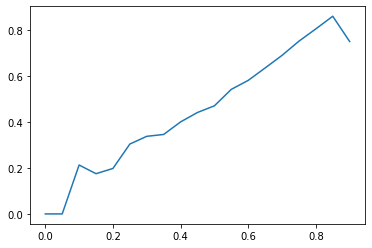

In [343]:
plt.plot(gini_tree.set_index('buckets'))
plt.show()

### GridSearch for Random Forest

In [346]:
from sklearn.ensemble import RandomForestClassifier

In [467]:
len(x_train_0.columns)
X, Y = create_features(MLB_DF, False)
x_train_0, x_test_0, y_train, y_test = seasonal_train_test_split(X, Y) # why standrardscale when you couldn't?

# Drop ERA, AVG, SLG
x_train = x_train_0.drop(labels = ['AVG_difference', 'SLG_difference', 'BAA_difference', 'IP_Start_difference',
],
                      axis = 1)
x_test = x_test_0.drop(labels = ['AVG_difference', 'SLG_difference', 'BAA_difference', 'IP_Start_difference',
],
                    axis = 1)

In [452]:
param_grid = {
    'n_estimators': [10, 20, 40, 60, 80],
    'criterion': ['gini'],
    'max_depth': [2, 3, 5, 7, 8],
    'max_features': ['auto'],
    'random_state': [499]
}
clf_rf = GridSearchCV(RandomForestClassifier(), 
             param_grid, cv=5, n_jobs = -1)

In [453]:
clf_rf.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [454]:
print("Optimal: ", clf_rf.best_params_)

Optimal:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 60, 'random_state': 499}


In [455]:
print("Score: ", clf_rf.best_score_)

Score:  0.6218056670623825


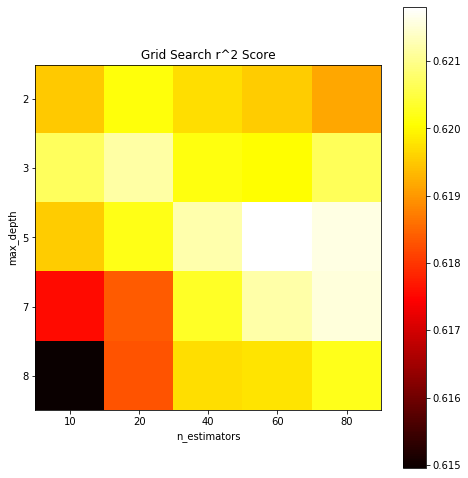

In [456]:
scores = clf_rf.cv_results_['mean_test_score'].reshape(5, 5)

plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.colorbar()
plt.xticks(np.arange(5), [10, 20, 40, 60, 80])
plt.yticks(np.arange(5), [2,3,5,7, 8])
plt.title('Grid Search r^2 Score')
plt.show()
maxDepth=clf_rf.best_params_['max_depth']
nEstimators=clf_rf.best_params_['n_estimators']

In [457]:
clf_rf.cv_results_['mean_test_score']

array([0.61952219, 0.62012918, 0.61972449, 0.61955101, 0.61917523,
       0.6207072 , 0.6211697 , 0.62015808, 0.6200424 , 0.62067831,
       0.61955091, 0.62021572, 0.62122759, 0.62180567, 0.62160335,
       0.61755649, 0.61839475, 0.62033144, 0.62119856, 0.62154545,
       0.61495525, 0.61830826, 0.61972447, 0.61978224, 0.62024477])

In [458]:
gsrf = RandomForestClassifier(n_estimators = nEstimators, max_depth = maxDepth, random_state = 499)

In [459]:
gsrf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=499,
                       verbose=0, warm_start=False)

In [460]:
gsrf.score(x_train, y_train)

0.6288299225343971

In [461]:
gsrf.score(x_test, y_test)

0.6224419007977801

In [463]:
pd.Series(gsrf.feature_importances_, index = x_train.columns).sort_values(ascending = False)

OBP_difference         0.328323
SLG_difference         0.265540
AVG_difference         0.181713
ISO_difference         0.095540
ELO_difference         0.023135
FIP_difference         0.020406
ERA_difference         0.017876
K/BB_difference        0.016508
WHIP_difference        0.015807
K9_difference          0.014669
IP_Start_difference    0.007920
BAA_difference         0.007500
HR9_difference         0.004511
rest_difference        0.000551
dtype: float64

### XGBOOST

In [466]:
from xgboost import XGBClassifier

In [819]:
len(x_train_0.columns)
X, Y = create_features(MLB_DF, True)
x_train_0, x_test_0, y_train, y_test = seasonal_train_test_split(X, Y) # why standrardscale when you couldn't?

# Drop ERA, AVG, SLG
# x_train = x_train_0.drop(labels = ['AVG_difference', 'SLG_difference', 'BAA_difference', 'IP_Start_difference',
# ],
#                       axis = 1)
# x_test = x_test_0.drop(labels = ['AVG_difference', 'SLG_difference', 'BAA_difference', 'IP_Start_difference',
# ],
#                     axis = 1)
x_train = x_train_0.drop(labels = ['AVG_difference_PCT', 'SLG_difference_PCT', 
                                   'BAA_difference_PCT', 'IP_Start_difference_PCT',
],
                      axis = 1)
x_test = x_test_0.drop(labels = ['AVG_difference_PCT', 'SLG_difference_PCT', 
                                 'BAA_difference_PCT', 'IP_Start_difference_PCT',
],
                    axis = 1)

In [817]:
home_bias = (math.exp(logitELN.intercept_[0]))/(
    1 + math.exp(logitELN.intercept_[0]))
print(home_bias)

0.5443592043436826


In [812]:
model = XGBClassifier(base_score = home_bias,
                     random_state = 499,
                     n_jobs = -1)

In [540]:
from sklearn.model_selection import RandomizedSearchCV

In [764]:
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.2, 0.24, 0.251],
    'n_estimators': [15, 20, 30],
    'subsample': [0.62, 0.69, 0.76, 0.83, 0.9],
    'cv': [5]
}

In [765]:
rscv = RandomizedSearchCV(model, param_grid)

In [766]:
rscv.fit(x_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5443592043436826,
                                           booster=None, colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_c...
                                           subsample=None, tree_method=None,
                                           validate_parameters=False,
                                           verbosity=None),
                 

In [767]:
rscv.best_params_

{'subsample': 0.9,
 'n_estimators': 20,
 'max_depth': 3,
 'learning_rate': 0.24,
 'cv': 5}

In [813]:
model_rscv = XGBClassifier(base_score = home_bias,
            n_estimators = 20,
           max_depth = 3,
           learning_rate = 0.24,
           subsample = 0.69,                
             random_state = 499,
                     n_jobs = -1,
                          cv = 5)

In [820]:
model_rscv.fit(x_train, y_train)
model_rscv.score(x_test, y_test)

0.6248699271592092

In [821]:
model_rscv.score(x_train, y_train)

0.6259683200369985

### SVC

In [748]:
from sklearn.svm import SVC

In [823]:
len(x_train_0.columns)
X, Y = create_features(MLB_DF, False)
x_train_0, x_test_0, y_train, y_test = seasonal_train_test_split(X, Y) # why standrardscale when you couldn't?

# Drop ERA, AVG, SLG
x_train = x_train_0.drop(labels = ['AVG_difference', 'SLG_difference', 'BAA_difference', 'IP_Start_difference',
],
                      axis = 1)
x_test = x_test_0.drop(labels = ['AVG_difference', 'SLG_difference', 'BAA_difference', 'IP_Start_difference',
],
                    axis = 1)

In [824]:
svc_model = SVC(random_state = 499,
               degree = 6, C = 100)

In [825]:
svc_model.fit(x_train, y_train)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=6, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=499, shrinking=True, tol=0.001,
    verbose=False)

In [826]:
svc_model.score(x_test, y_test)

0.615071106486299

In [827]:
svc_model.score(x_train, y_train)

0.6156492080009249

In [828]:
# Let's try another one
svc_model = SVC(random_state = 499,
               degree = 5, C = 5)

In [829]:
sclr = StandardScaler()
x_train1 = sclr.fit_transform(x_train)
x_test1 = sclr.transform(x_test)

In [830]:
svc_model.fit(x_train1, y_train)

SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=5, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=499, shrinking=True, tol=0.001,
    verbose=False)

In [831]:
svc_model.score(x_train1, y_train)

0.6406520985084981

In [832]:
svc_model.score(x_test1, y_test)

0.6223551855705862

In [833]:
# Let's try another one
svc_model = SVC(random_state = 499,
               degree = 3, C = 10**(-2))

In [834]:
svc_model.fit(x_train1, y_train)

SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=499, shrinking=True, tol=0.001,
    verbose=False)

In [835]:
svc_model.score(x_train1, y_train)

0.6174124176205341

In [836]:
svc_model.score(x_test1, y_test)

0.6187998612556365

What happens when we don't scale?

In [797]:
# Let's try another one
svc_model = SVC(random_state = 499,
               degree = 3, C = 10**(-2))
svc_model.fit(x_train, y_train)

SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=499, shrinking=True, tol=0.001,
    verbose=False)

In [798]:
print(svc_model.score(x_train, y_train))
print(svc_model.score(x_test, y_test))

0.6104751994450226
0.6122962192160943


### MLAutomator

In [516]:
# from mlautomator.mlautomator import MLAutomator

# automator = MLAutomator(x_train, y_train, iterations = 1)

In [517]:
# automator.find_best_algorithm()

In [518]:
# automator.print_best_space()

### SGD
Logistic probabilities - doubled early stopping

In [519]:
from sklearn.linear_model import SGDClassifier

In [535]:
sgd = SGDClassifier(random_state = 499, n_iter_no_change = 10, loss='log')
sgd.fit(x_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=10, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=499, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [536]:
sgd.score(x_train, y_train)

0.5845762515897792

In [537]:
sgd.score(x_test, y_test)

0.5815123135622615

### KNN

Doesn't make as much sense because we can't really build rules as well

In [799]:
from sklearn.neighbors import KNeighborsClassifier


In [800]:
sclr = StandardScaler()
x_train1 = sclr.fit_transform(x_train)
x_test1 = sclr.transform(x_test)

In [802]:
knnclf1 = KNeighborsClassifier(n_neighbors = 10, 
                    weights = 'uniform',
                    algorithm = 'auto')

In [803]:
knnclf2 = KNeighborsClassifier(n_neighbors = 10, 
                    weights = 'distance',
                    algorithm = 'auto')

In [804]:
knnclf1.fit(x_train1, y_train)
print(knnclf1.score(x_train1, y_train))
print(knnclf1.score(x_test1, y_test))

0.6740374609781478
0.5865417967395075


In [805]:
knnclf2.fit(x_train1, y_train)
print(knnclf2.score(x_train1, y_train))
print(knnclf2.score(x_test1, y_test))

0.9998265695456122
0.5882761012833854


In [806]:
knnclf3 = KNeighborsClassifier(n_neighbors = 5, 
                    weights = 'uniform',
                    algorithm = 'auto')

knnclf4 = KNeighborsClassifier(n_neighbors = 5, 
                    weights = 'distance',
                    algorithm = 'auto')

In [808]:
knnclf3.fit(x_train1, y_train)
knnclf4.fit(x_train1, y_train)

print(knnclf3.score(x_train1, y_train))
print(knnclf3.score(x_test1, y_test))

print(knnclf4.score(x_train1, y_train))
print(knnclf4.score(x_test1, y_test))

0.7226557983581917
0.5763961151578217
0.9998265695456122
0.5751821019771072
